# 

# Proprietary Gaussian and Laplacian Attention Mechanisms

In [1]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install gaussian_adaptive_attention
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd
import utils
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/opt/homebrew/Caskroom/miniconda/base/envs/AML/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Objective

Here we depart from the GAAM paper and attempt to implement our own self-attention mechanisms from scratch. First we do so for a Gaussian distribution, then also for a Laplacian distribution.

The setup is the same as the one we used in notebook `07-two-model-architecture.ipynb`. We run the input through the GPT2-model to extract its deep features, and we then feed these into a second classifier network which utilizes our proprietary Gaussian/Laplacian attention mechanism.

In [3]:
class GPT2WithIntermediateOutputs(GPT2Model):

    def __init__(self, config):

        super().__init__(config)

    def forward(self, input_ids, attention_mask=None):

        # Get embeddings from input

        input_shape = input_ids.size()

        input_ids = input_ids.view(-1, input_shape[-1])

        device = input_ids.device

        if attention_mask is None:

            attention_mask = torch.ones(input_shape, device=device)

        # Prepare attention mask

        if attention_mask.dim() == 3:

            extended_attention_mask = attention_mask[:, None, :, :]

        elif attention_mask.dim() == 2:

            extended_attention_mask = attention_mask[:, None, None, :]

        # Prepare head mask if needed

        head_mask = self.get_head_mask(None, self.config.n_layer)

        # Transformer layers

        hidden_states = self.wte(input_ids) + self.wpe(torch.arange(0, input_shape[-1], device=device))

        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        all_hidden_states = torch.empty((*output_shape, self.config.n_layer + 1), device=device)

        all_hidden_states[..., 0] = hidden_states

        for i, (block, layer_past) in enumerate(zip(self.h, [None]*len(self.h))):

            outputs = block(hidden_states, layer_past=layer_past, attention_mask=extended_attention_mask, head_mask=head_mask[i])

            hidden_states = outputs[0]

            all_hidden_states[..., i+1] = hidden_states

        # Concatenate all hidden states

        concatenated_outputs = all_hidden_states.permute(2, 0, 1, 3).reshape(self.config.n_layer + 1, -1, hidden_states.size(-1))

        return concatenated_outputs


# Example usage:

config = GPT2Config.from_pretrained("gpt2")

model = GPT2WithIntermediateOutputs(config)

print(model)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_ids = torch.tensor([tokenizer.encode("if the vocabulary is known, then the sequence length is correct")])

# Output will have dimensions: [num_layers + 1, batch_size, seq_length, features] (discard element 0 , that's the embedding initial layer)

outputs = model(input_ids)


print(outputs.shape)  # Output dimensions

/opt/homebrew/Caskroom/miniconda/base/envs/AML/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2WithIntermediateOutputs(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
torch.Size([13, 12, 768])


In [4]:
dataset = load_dataset('ag_news')

dataset_train_1percent = utils.take_a_percentage_of_data(dataset['train'], percentage=0.01)
dataset_test_1percent = utils.take_a_percentage_of_data(dataset['test'], percentage=0.01)

combined_dataset_1percent = DatasetDict({
    'train': dataset_train_1percent,
    'test': dataset_test_1percent
})


## Definition of the Gaussian Attention Mechanism

In [5]:
class GaussianAttentionClassifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(GaussianAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # Transformation layer for values
        self.value_transform = nn.Linear(hidden_dim, hidden_dim)

        # Parameters for Gaussian attention
        self.mean = nn.Parameter(torch.rand(1))  # Learnable mean
        self.std_dev = nn.Parameter(torch.rand(1))  # Learnable standard deviation

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.shape

        # Dynamically create position indices based on sequence length
        position_indices = torch.arange(seq_length, device=x.device).float().unsqueeze(0)  # [1, seq_length]

        # Transform input for values
        values = self.value_transform(x)  # [batch_size, seq_length, hidden_dim]

        # Calculate Gaussian attention weights
        position_diff = position_indices - self.mean  # [1, seq_length]
        exponent = -0.5 * ((position_diff / self.std_dev) ** 2)
        gaussian_weights = torch.exp(exponent)  # [1, seq_length]
        gaussian_weights = gaussian_weights / gaussian_weights.sum()  # Normalize weights
        gaussian_weights = gaussian_weights.repeat(batch_size, 1).unsqueeze(1)  # [batch_size, 1, seq_length]

        # Apply masking if provided
        if mask is not None:
            mask = mask.float().unsqueeze(1)  # [batch_size, 1, seq_length]
            gaussian_weights *= mask  # Apply mask to Gaussian weights

        # Apply Gaussian attention
        context = torch.bmm(gaussian_weights, values)  # [batch_size, 1, hidden_dim]
        x = context.squeeze(1)  # [batch_size, hidden_dim]

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Parameters
hidden_dim = 768
num_classes = 4

# Create the classifier with Gaussian attention
gaussian_attention_classifier = GaussianAttentionClassifier(hidden_dim, num_classes)

## Definition of the Laplacian Attention Mechanism

In [6]:
class LaplacianAttentionClassifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(LaplacianAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # Transformation layer for values
        self.value_transform = nn.Linear(hidden_dim, hidden_dim)

        # Parameters for Laplacian attention
        self.mean = nn.Parameter(torch.rand(1))  # Learnable mean
        self.scale = nn.Parameter(torch.rand(1))  # Learnable scale (equivalent to the b parameter in the Laplacian distribution)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.shape

        # Dynamically create position indices based on sequence length
        position_indices = torch.arange(seq_length, device=x.device).float().unsqueeze(0)  # [1, seq_length]

        # Transform input for values
        values = self.value_transform(x)  # [batch_size, seq_length, hidden_dim]

        # Calculate Laplacian attention weights
        position_diff = position_indices - self.mean  # [1, seq_length]
        laplacian_weights = torch.exp(-torch.abs(position_diff) / self.scale)  # [1, seq_length]
        laplacian_weights = laplacian_weights / laplacian_weights.sum()  # Normalize weights
        laplacian_weights = laplacian_weights.repeat(batch_size, 1).unsqueeze(1)  # [batch_size, 1, seq_length]

        # Apply masking if provided
        if mask is not None:
            mask = mask.float().unsqueeze(1)  # [batch_size, 1, seq_length]
            laplacian_weights *= mask  # Apply mask to Laplacian weights

        # Apply Laplacian attention
        context = torch.bmm(laplacian_weights, values)  # [batch_size, 1, hidden_dim]
        x = context.squeeze(1)  # [batch_size, hidden_dim]

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Parameters
hidden_dim = 768
num_classes = 4

# Create the classifier with Laplacian attention
laplacian_attention_classifier = LaplacianAttentionClassifier(hidden_dim, num_classes)

In [7]:
# Here we take our dataset, and run it throught the GPT2WithIntermediateOutputs to obtain our intermediate states we then save this to a pkl file.
utils.pickilisation(combined_dataset_1percent, tokenizer, model, 'test')
utils.pickilisation(combined_dataset_1percent, tokenizer, model, 'train')

## Training

In [8]:
def train_classifier(classifier, data_path, batch_size=20, num_epochs=20, learning_rate=0.01, device=None):
    # Determine device if not provided
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load processed data
    with open(data_path, 'rb') as f:
        processed_data = pickle.load(f)

    # Prepare optimizer and loss criterion
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Move classifier to the appropriate device
    classifier.to(device)
    classifier.train()

    # Prepare data
    features, labels = zip(*processed_data)
    num_batches = len(features) // batch_size

    # Store loss for plotting
    epoch_losses = []

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0

        for i in range(0, len(features), batch_size):
            optimizer.zero_grad()

            for f, label in zip(features[i:i+batch_size], labels[i:i+batch_size]):
                x = torch.tensor(f).view(1, -1, 768).to(device)
                y = torch.tensor([label], dtype=torch.long).to(device)

                output = classifier(x)
                loss = criterion(output, y)
                loss.backward()
                total_loss += loss.item()

            optimizer.step()

        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}: Average Loss: {avg_loss:.2f}")

    return epoch_losses

Training classifer with GAAM
--------------


/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_1598/1549110909.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(f).view(1, -1, 768).to(device)


Epoch 1/100: Average Loss: 27.82
Epoch 2/100: Average Loss: 27.13
Epoch 3/100: Average Loss: 26.38
Epoch 4/100: Average Loss: 25.21
Epoch 5/100: Average Loss: 24.16
Epoch 6/100: Average Loss: 22.20
Epoch 7/100: Average Loss: 20.58
Epoch 8/100: Average Loss: 19.02
Epoch 9/100: Average Loss: 17.19
Epoch 10/100: Average Loss: 15.63
Epoch 11/100: Average Loss: 13.70
Epoch 12/100: Average Loss: 13.83
Epoch 13/100: Average Loss: 11.89
Epoch 14/100: Average Loss: 9.02
Epoch 15/100: Average Loss: 7.43
Epoch 16/100: Average Loss: 7.12
Epoch 17/100: Average Loss: 6.33
Epoch 18/100: Average Loss: 7.03
Epoch 19/100: Average Loss: 7.41
Epoch 20/100: Average Loss: 5.06
Epoch 21/100: Average Loss: 4.48
Epoch 22/100: Average Loss: 3.62
Epoch 23/100: Average Loss: 3.97
Epoch 24/100: Average Loss: 3.86
Epoch 25/100: Average Loss: 3.00
Epoch 26/100: Average Loss: 3.06
Epoch 27/100: Average Loss: 2.48
Epoch 28/100: Average Loss: 1.49
Epoch 29/100: Average Loss: 0.72
Epoch 30/100: Average Loss: 0.43
Epoch 

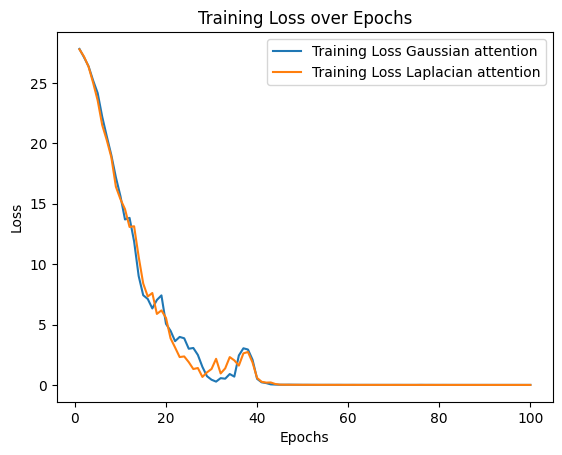

In [9]:
# Parameters
hidden_dim = 768
num_classes = 4
batch_size = 20
num_epochs = 100
learning_rate = 0.001
data_path = 'processed_train_data.pkl'

# Create the classifier with Laplacian attention
classifier1 = gaussian_attention_classifier
classifier2 = laplacian_attention_classifier

# Train the classifiers
print("Training classifer with GAAM\n--------------")
epoch_losses1 = train_classifier(classifier1, data_path, batch_size, num_epochs, learning_rate)
print("Training classifer with LAAM\n--------------")
epoch_losses2 = train_classifier(classifier2, data_path, batch_size, num_epochs, learning_rate)

# Plot the training loss over epochs for both classifiers
plt.plot(range(1, num_epochs + 1), epoch_losses1, label='Training Loss Gaussian attention')
plt.plot(range(1, num_epochs + 1), epoch_losses2, label='Training Loss Laplacian attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [22]:
def compute_accuracy(classifier, data_path, device=None):
    # Determine device if not provided
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load processed data
    with open(data_path, 'rb') as f:
        processed_data = pickle.load(f)

    # Move classifier to the appropriate device
    classifier.to(device)
    classifier.eval()

    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    for x, label in processed_data:
        x = torch.tensor(x).to(device)
        label = torch.tensor([label], dtype=torch.long).to(device)

        with torch.no_grad():
            flattened = x.view(1, -1, 768)
            output = classifier(flattened)
            predicted_label = torch.argmax(output, dim=1)
            #print(f"Predicted: {predicted_label.item()}, Actual: {label.item()}")

        correct_predictions += (predicted_label == label).sum().item()
        total_predictions += label.size(0)

        all_predictions.append(predicted_label.item())
        all_labels.append(label.item())

    accuracy = correct_predictions / total_predictions
    
    return accuracy, all_labels, all_predictions



# Specify the path to the dataset
data_path = 'processed_train_data.pkl'

# Compute accuracy
acc_gau, all_labels_gau, all_predictions_gau = compute_accuracy(gaussian_attention_classifier, data_path)
acc_lap, all_labels_lap, all_predictions_lap= compute_accuracy(laplacian_attention_classifier,data_path)

print(f"Accuracy for gaussian classifier on training set: {acc_gau:.4f}")
print(f"Accuracy for laplacian classifier on training set: {acc_lap:.4f}")


/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_1598/1738511571.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


Accuracy for gaussian classifier on training set: 1.0000
Accuracy for laplacian classifier on training set: 1.0000


In [23]:
# Specify the path to the dataset
data_path = 'processed_test_data.pkl'

# Compute accuracy
acc_gau, all_labels_gau, all_predictions_gau  = compute_accuracy(gaussian_attention_classifier, data_path)
acc_lap, all_labels_lap, all_predictions_lap = compute_accuracy(laplacian_attention_classifier,data_path)

print(f"Accuracy for gaussian classifier on test set: {acc_gau:.4f}")
print(f"Accuracy for laplacian classifier on test set: {acc_lap:.4f}")


/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_1598/1738511571.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


Accuracy for gaussian classifier on test set: 0.3158
Accuracy for laplacian classifier on test set: 0.2368


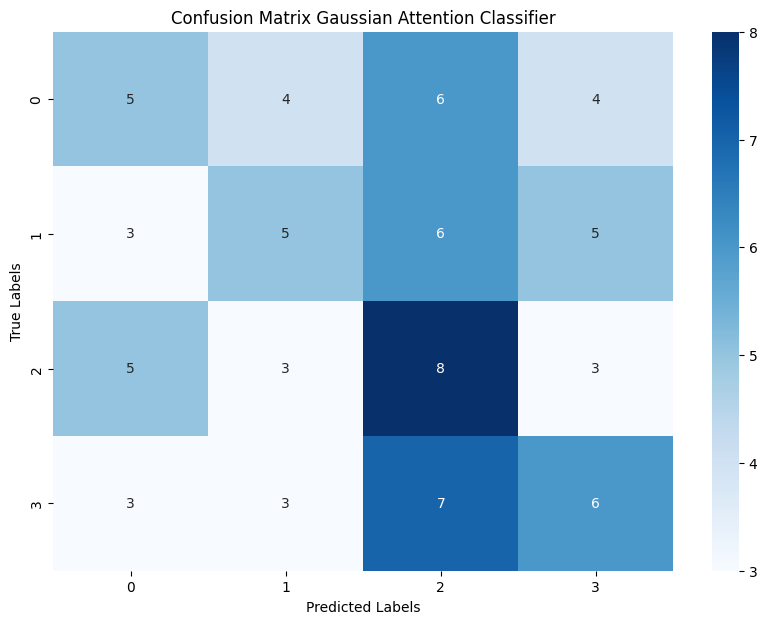

In [27]:
def plot_confusion_matrix(labels, predictions):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_gau), yticklabels=np.unique(all_labels_gau))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Gaussian Attention Classifier')
    plt.show()

plot_confusion_matrix(all_labels_gau, all_predictions_gau)

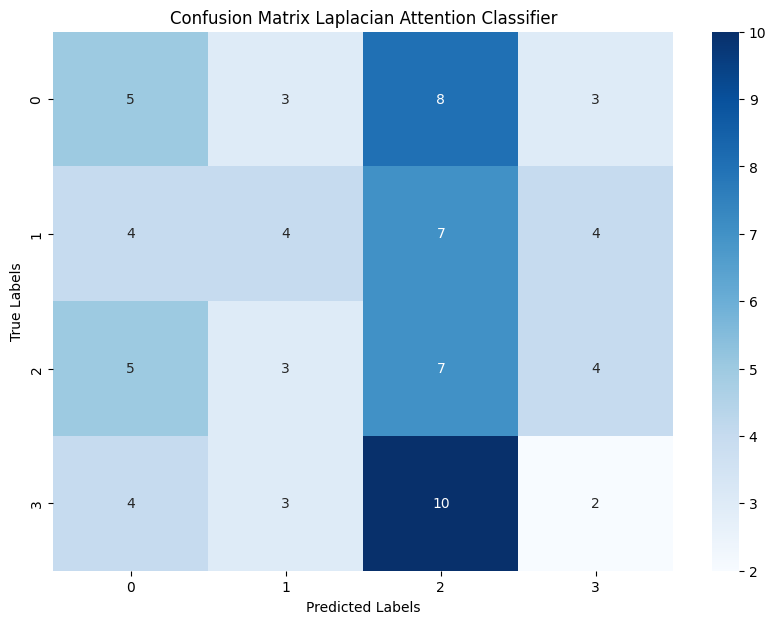

In [26]:
plot_confusion_matrix(all_labels_lap, all_predictions_lap)

## Conclusion

We trained the two models for 100 epochs on 1% of the training data. After about 50 epochs, the loss decreased to zero for both models. Both models reach an accuracy of 100% on the training data set, so both models are capable of learning. If we look at the accuracy on the test data set, we see that the model with GAAM reaches an accuracy of 32.58% and the model with LAAM reaches an accuracy of 23.68%. At least for the GAAM model, this is better than a random classifier, which would achieve an accuracy of 25% on these four equally distributed classes. The LAAM model is slightly below the 25% benchmark. Probably the results could be improved by training on more training data or playing around with the hyper-parameters. Due to lack of resources we couldn't investigate this further. 

However, we see potential for both of these attention mechanisms and we would be interested to see how they would perform with well-chosen hyperparameters after being trained on a larger amount of data for a substantial number of epochs.